##  Github Language Predictor (NLP) - Steven G  &  Gary G

In [1]:
import pandas as pd
import numpy as np
from requests import get
from bs4 import BeautifulSoup
import os
import re

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, accuracy_score
from math import log

%matplotlib inline
import matplotlib.pyplot as plt


## Data acquisition

Scrape the urls from the GitHub "trending" repository sites and "most starred" repositores

In [2]:
def get_GitHub_trend(url):
    url = 'https://github.com/trending'
    headers = {'User-Agent': 'Codeup Ada Data Science'} # codeup.com doesn't like our default user-agent
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    title = soup.title
    #  pull the GitHub Trending repositories
    trending = soup.find_all('div', class_= 'd-inline-block')
    #  find all the "hrefs", which are the trending titles
    re.findall(r'href="(.*?)"', str(trending))
    return trending
    

In [3]:
# . turn this off for now, until access limit is removed
#  trending = get_GitHub_trend('https://github.com/trending')

Trending Github only gave us about 20 sites (need at least 100).

During this process GitHub blocked access to the class because of all the web hits, so we manually saved off the html pages to the working directory and parsed from there. 

Added websites from "most starred" GitHub repositories,  sorted by highest to lowest - pulled the top 13 pages to get 100 additional repos (see "list_of_html_files").  Raw htmll pages are stored in 
repository and can be parsed from scratch. 


####  For quick loading, these 13 parsed pages are stored in "git_repo_nlp.csv"

Went back for more repositories because we didn't have a reasonable number of spread samples for the different languages. 

#### Second file (addtional data) is 'github_data.csv'.

The bool variable "read_from_web", causes the data acquire to read straight from the two parsed csv file for speed. 

In [4]:
# scrape GitHub repositories with the most stars
def get_GitHub_most_stars(url = 'https://github.com/search?o=desc&q=stars%3A%3E0&s=stars&type=Repositories'):
    headers = {'User-Agent': 'Codeup Ada Data Science'} 
    response = get(url, headers=headers)
    contents = response.content
    return contents

In [5]:
# read the html file from a file in the curent working directory ('GitHubTopStars_repos.html')
def read_GitHub_most_stars(filename):
    with open(filename) as f:
        contents = f.read()
    return contents

In [6]:
def parse_urls(contents):
    soup = BeautifulSoup(contents, 'html.parser')
    title = soup.title
    orig_text = soup.text
    stars = soup.find_all('a', class_= 'v-align-middle')
    #  find all the "hrefs", which are the trending titles
    return(re.findall(r'href="(.*?)"', str(stars)))


In [7]:

# Grabs the language and body for each git repo as a dictionary and adds to a list
def get_git_info(star_list):
    
    github_base_url = 'https://github.com'
    git_repo_url = []
    
    for repo in star_list:
        git_repo_url.append(github_base_url + repo)

    list_of_git_info = []

    for repo_address in git_repo_url:
        git_repo_url = repo_address 
        headers = {'User-Agent': 'Codeup Ada Data Science'}
        response = get(git_repo_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        language = soup.find('span', class_='lang')

#       This adds the part to get to the readme and scrapes the body  
        readme_end = '/blob/master/README.md'
        readme_url = git_repo_url + readme_end
        headers = {'User-Agent': 'Codeup Ada Data Science'}
        response = get(readme_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        body = soup.find('article', class_="markdown-body entry-content p-3 p-md-6")

#       Combines the language and body to a dictionary, if no language on the repo it is ignored
        if language != None:
            language = str(language)
            list_of_git_info.append({'Language': re.findall(r'>(.*?)<', language)[0],
                                     'Body': body})

    return list_of_git_info


def drop_empty_readmes(repos):
    output = []
    for repo in repos:
        if repo['Body'] != None:
            output.append(repo)
    return output




def basic_clean(repo):
    repo = re.sub(r'\s', ' ', repo).lower()
    repo = unicodedata.normalize('NFKD', repo)\
        .encode('ascii', 'ignore')\
        .decode('utf-8', 'ignore')
    repo = re.sub(r"[^a-z0-9'\s]", '', repo)
    return repo

# Finds the number of unique words 
def find_nunique(string):
    words = string.split(" ")
    unique_words = set(words)
    return len(unique_words)

def regex_it(string):
    return ' '.join(re.findall(r'[a-z]+', string))


def tokenize(repo):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    repo = tokenizer.tokenize(repo, return_str=True)
    return repo
    

def stem(repo):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in repo.split()]
    repo_stemmed = ' '.join(stems)
    return repo_stemmed


def lemmatize(repo):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in repo.split()]
    repo_lemmatized = ' '.join(lemmas)
    return repo_lemmatized


def remove_stopwords(repo, extra_words = [], exclude_words = []):
    stopword_list = stopwords.words('english')
    [stopword_list.append(word) for word in extra_words if word not in stopword_list]
    [stopword_list.remove(word) for word in exclude_words if word in stopword_list]
    words = repo.lower().split()
    filtered_words = [w for w in words if w not in stopword_list]
    repo_without_stopwords = ' '.join(filtered_words)
    return repo_without_stopwords


def prep_repo(dictionary_repo, extra_words = [], exclude_words = []):
    cleaned_dict = {
    'language': dictionary_repo['Language'],
    'original': dictionary_repo['Body'],
    'stemmed': stem(dictionary_repo['Body']),
    'lemmatized': lemmatize(dictionary_repo['Body']),
    'clean': remove_stopwords(basic_clean(dictionary_repo['Body']), extra_words, exclude_words),
        }

    return cleaned_dict

def prepare_repo_data(dictionary_repo, extra_words = [], exclude_words = []):
    clean_dict_list = []
    
    for repo in dictionary_repo:
        clean_dict_list.append(prep_repo(repo, extra_words, exclude_words))
        
    return clean_dict_list

def get_df(bulk):
    return pd.DataFrame(prepare_repo_data(bulk))

In [8]:
#  turn off the web access for now and just read the cached files from the working directory
#  contents = get_GitHub_most_stars()
list_of_html_files = ['GitHubTopStars_repos-page1.html','GitHubTopStars_repos-page2.html',\
                      'GitHubTopStars_repos-page3.html','GitHubTopStars_repos-page4.html',\
                      'GitHubTopStars_repos-page5.html','GitHubTopStars_repos-page6.html',\
                      'GitHubTopStars_repos-page7.html','GitHubTopStars_repos-page8.html',\
                      'GitHubTopStars_repos-page9.html','GitHubTopStars_repos-page10.html',\
                      'GitHubTopStars_repos-page11.html','GitHubTopStars_repos-page12.html',\
                      'GitHubTopStars_repos-page13.html']

star_list = []
for html_file in list_of_html_files:
    contents = read_GitHub_most_stars(html_file)
    next_list = parse_urls(contents)
    star_list = star_list + next_list


In [9]:
read_from_web = False
if read_from_web == True:
    github_base_url = 'https://github.com'
    git_repo_url = []
    for repo in star_list:
        git_repo_url.append(github_base_url + repo)
    
    bulk = get_git_info(star_list)  
    bulk = drop_empty_readmes(bulk)
    for repo in bulk:
        repo['Body'] = repo['Body'].text.strip()
  
    df = get_df(bulk)
else:
    df = pd.read_csv('git_repo_nlp.csv') 
    df2 = pd.read_csv('github_data.csv', index_col=0)
    df2.rename(columns={'readme': 'original'}, inplace=True)
    df2['clean'] = df2.original.apply(remove_stopwords, basic_clean)
    df = df.append(df2)


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [10]:
# removing the low pop ones, under 10

df = df[df.language != 'CSS']
df = df[df.language != 'C']
df = df[df.language != 'HTML']
df = df[df.language != 'Shell']
df = df[df.language != 'Vue']
df = df[df.language != 'Ruby']
df = df[df.language != 'Kotlin']
df = df[df.language != 'Rust']
df = df[df.language != 'Dart']
df = df[df.language != 'Objective-C']
df = df[df.language != 'Swift']
df = df[df.language != 'Clojure']
df = df[df.language != 'Jupyter Notebook']
df = df[df.language != 'TeX']
df = df[df.language != 'C#']
df = df[df.language != 'Vim script']
df = df[df.language != 'Assembly']
df = df[df.language != 'Dockerfile']
df = df[df.language != 'PHP']



In [11]:
# Getting only words and stemming them

df.clean = df.clean.apply(regex_it)
df.clean = df.clean.apply(stem)

In [12]:
# getting the words for each language

all_words = ' '.join(df['clean'])
js_words = ' '.join(df['clean'][df.language == 'JavaScript'])
python_words = ' '.join(df['clean'][df.language == 'Python'])
cpp_words = ' '.join(df['clean'][df.language == 'C++'])
typeScript_words = ' '.join(df['clean'][df.language == 'TypeScript'])
go_words = ' '.join(df['clean'][df.language == 'Go'])
java_words = ' '.join(df['clean'][df.language == 'Java'])
# css_words = ' '.join(df['clean'][df.language == 'CSS'])


In [13]:
df.language.value_counts()

JavaScript    128
Python         40
Java           25
Go             22
C++            20
TypeScript     12
Name: language, dtype: int64

In [14]:
# finding the frequency for each word for each language

all_freq = pd.Series(all_words.split()).value_counts()
js_freq = pd.Series(js_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
cpp_freq = pd.Series(cpp_words.split()).value_counts()
typeScript_freq = pd.Series(typeScript_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
# css_freq = pd.Series(css_words.split()).value_counts()



In [15]:
# Bag of words

word_counts = (pd.concat([all_freq, js_freq, python_freq, cpp_freq,typeScript_freq,
                          go_freq, java_freq], axis=1, sort=True)
                .set_axis(['all', 'js', 'python', 'cpp', 'ts', 'go', 'java']\
                          , axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))



In [16]:
# word_counts.sort_values(by='all', ascending=False).head(5)

(-0.5, 399.5, 199.5, -0.5)

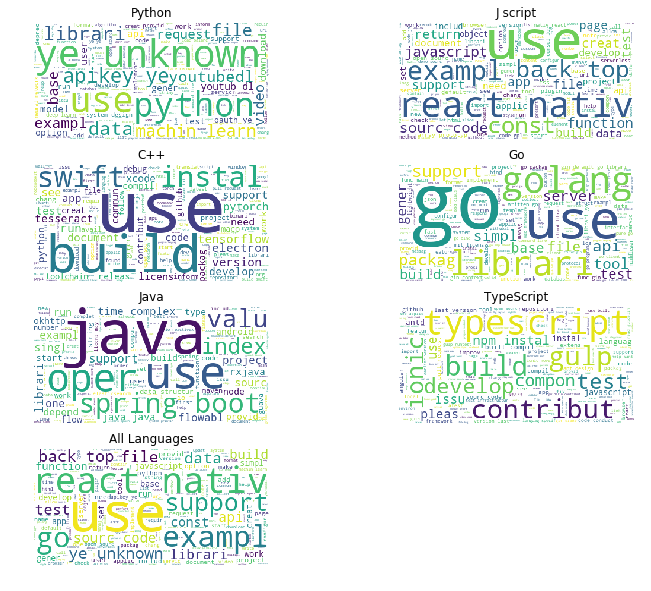

In [17]:
all_cloud = WordCloud(background_color='white').generate(all_words)
python_cloud = WordCloud(background_color='white').generate(python_words)
js_cloud = WordCloud(background_color='white').generate(js_words)
cpp_cloud = WordCloud(background_color='white').generate(cpp_words)
typeScript_cloud = WordCloud(background_color='white').generate(typeScript_words)
go_cloud = WordCloud(background_color='white').generate(go_words)
java_cloud = WordCloud(background_color='white').generate(java_words)
# css_cloud = WordCloud(background_color='white').generate(css_words)

plt.figure(figsize=(12, 10))

plt.subplot(421)
plt.imshow(python_cloud)
plt.title('Python')
plt.axis('off')

plt.subplot(422)
plt.imshow(js_cloud)
plt.title('J script')
plt.axis('off')

plt.subplot(423)
plt.imshow(cpp_cloud)
plt.title('C++')
plt.axis('off')

plt.subplot(424)
plt.imshow(go_cloud)
plt.title('Go')
plt.axis('off')

plt.subplot(425)
plt.imshow(java_cloud)
plt.title('Java')
plt.axis('off')

plt.subplot(426)
plt.imshow(typeScript_cloud)
plt.title('TypeScript')
plt.axis('off')

plt.subplot(427)
plt.imshow(all_cloud)
plt.title('All Languages')
plt.axis('off')



Does the length of the README vary by language?


In [18]:
df['readme_length'] = df.clean.str.len()
df[['language','readme_length']].groupby('language').mean().sort_values('readme_length', ascending=False)


,readme_length
language,
Python,16558.825000
Go,14339.272727
JavaScript,9536.562500
Java,2867.240000
C++,2757.850000
TypeScript,991.333333


Do different languages use a different number of unique words?

In [19]:
df['unique_words'] = df.clean.apply(find_nunique)
df[['language','unique_words']].groupby('language').mean().sort_values('unique_words', ascending=False)


,unique_words
language,
Python,667.175000
Go,606.636364
JavaScript,403.531250
C++,205.900000
Java,182.720000
TypeScript,94.166667


Calculate Inverse Document Frequency

In [20]:
def idf(word):
    #''' loop through all languages (string), transform into a list and then check for the occurence of the word 
    # in that language'''
    n_occurences = 0
    for language in list_of_languages:
        language_list = language.split()
        if word in language_list:
            n_occurences += 1
    return np.log(len(list_of_languages)/(n_occurences+0.1))


In [21]:
unique_words = pd.Series(all_words.split()).unique()
# get the top 30 words found in the documents, count their occurences in the corpus of languages, and store in a dataframe
word_stats_df = (pd.Series(all_words.split())).value_counts().sort_values(ascending=False)[:30].to_frame('frequency')
word_stats_df.index.names = ['word']
# make a duplicate of the index column so you can apply methods to it
word_stats_df['word'] = word_stats_df.index

In [22]:
list_of_languages = [js_words, python_words, cpp_words, \
                     typeScript_words, go_words, java_words] 
                     

In [23]:
word_stats_df['idf_score'] = word_stats_df.word.apply(idf) 

What does the distribution of IDFs look like for the most common words?

In [24]:
word_stats_df

,frequency,word,idf_score
word,,,
use,5021,use,-0.016529
go,2409,go,-0.016529
code,2141,code,-0.016529
react,2022,react,0.380772
nativ,1920,nativ,-0.016529
function,1878,function,0.162519
data,1874,data,0.162519
librari,1851,librari,0.162519
exampl,1784,exampl,-0.016529


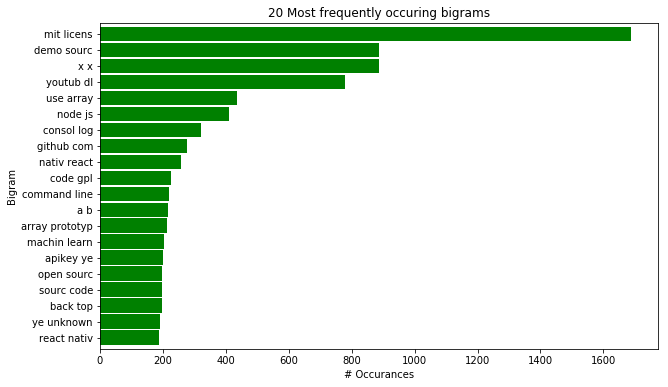

In [25]:
top_bigrams = (pd.Series(nltk.ngrams(all_words.split(), 2))
                      .value_counts()
                      .head(20))

top_bigrams.sort_values().plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [26]:
# Languages are very imbalanced
df.language.value_counts()

JavaScript    128
Python         40
Java           25
Go             22
C++            20
TypeScript     12
Name: language, dtype: int64

In [27]:
# Taking a sample of JS
sample_df = df[df['language']=='JavaScript'].sample(40, random_state=123)
non_js = df[df['language']!='JavaScript']
sample_df = sample_df.append(non_js)
sample_df.language.value_counts()

Python        40
JavaScript    40
Java          25
Go            22
C++           20
TypeScript    12
Name: language, dtype: int64

## The following models were run on a balanced dataset using Tfidf    (TfidfVectorizer)

a) LogisticRegression   (multinomial, newton-cg)    75% Accuracy

b) DecisionTree   (maxdepth=25)                     46.88% Accuracy

c) RandomForest                                     71.88% Accuracy

d) KNeighborsClassifier(n_neighbors=2)              78.12% Accuracy

e) MultinomialNB                                    56.25% Accuracy

f) LinearSVC                                        81.25% Accuracy

(accuracies reported on test data set)

In [28]:
#   Running with balanced numbers
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(sample_df.clean)
y = sample_df.language

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [30]:
lm = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 99.21%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          15   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0          32       0           0
Python        1   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      0.94      0.97        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00        32
      Python       0.97      1.00      0.98        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       0.99      0.9

In [31]:
lm = DecisionTreeClassifier(max_depth=25).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0          32       0           0
Python        0   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00        32
      Python       1.00      1.00      1.00        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       1.00      1.

In [32]:
lm = RandomForestClassifier().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0          32       0           0
Python        0   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00        32
      Python       1.00      1.00      1.00        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       1.00      1.

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [33]:
lm = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 92.91%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       1           0
Go            0  17     1           1       2           0
Java          0   0    19           0       1           0
JavaScript    0   0     0          31       3           0
Python        0   0     0           0      25           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       0.94      1.00      0.97        16
          Go       0.81      1.00      0.89        17
        Java       0.95      0.95      0.95        20
  JavaScript       0.91      0.97      0.94        32
      Python       1.00      0.78      0.88        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       0.93      0.9

In [34]:
lm = MultinomialNB().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 80.31%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++           5   0     0           0       0           0
Go            0  11     0           0       0           0
Java          0   0    19           0       0           0
JavaScript    8   1     0          32       0           7
Python        3   5     1           0      32           0
TypeScript    0   0     0           0       0           3
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      0.31      0.48        16
          Go       1.00      0.65      0.79        17
        Java       1.00      0.95      0.97        20
  JavaScript       0.67      1.00      0.80        32
      Python       0.78      1.00      0.88        32
  TypeScript       1.00      0.30      0.46        10

   micro avg       0.80      0.8

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
lm = LinearSVC().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0          32       0           0
Python        0   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00        32
      Python       1.00      1.00      1.00        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       1.00      1.

## The following models were run using Bag of Words  (CountVectorizer) on a balanced dataset

a) LogisticRegression   (multinomial, newton-cg)  75% Accuracy

b) DecisionTree   (maxdepth=25)                   65.62% Accuracy

c) RandomForest                                   65.62% Accuracy

d) KNeighborsClassifier(n_neighbors=2)            53.12% Accuracy

e) MultinomialNB                                  78.12% Accuracy

f) LinearSVC                                      75% Accuracy

(accuracies reported on test data set)

In [36]:
# Running with balanced numbers
cv = CountVectorizer()
X = cv.fit_transform(sample_df.clean)
y = sample_df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [37]:
lm = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0          32       0           0
Python        0   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00        32
      Python       1.00      1.00      1.00        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       1.00      1.

In [38]:
lm = DecisionTreeClassifier(max_depth=25, random_state=123).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0          32       0           0
Python        0   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00        32
      Python       1.00      1.00      1.00        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       1.00      1.

In [39]:
lm = RandomForestClassifier().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0          32       0           0
Python        0   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00        32
      Python       1.00      1.00      1.00        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       1.00      1.

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [40]:
lm = MultinomialNB().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 93.70%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       1           0
Java          0   0    20           0       0           0
JavaScript    0   0     0          32       1           6
Python        0   0     0           0      30           0
TypeScript    0   0     0           0       0           4
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       0.94      1.00      0.97        17
        Java       1.00      1.00      1.00        20
  JavaScript       0.82      1.00      0.90        32
      Python       1.00      0.94      0.97        32
  TypeScript       1.00      0.40      0.57        10

   micro avg       0.94      0.9

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
lm = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 88.98%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   1     0           1       2           0
Go            0  16     1           1       1           0
Java          0   0    19           1       1           0
JavaScript    0   0     0          29       4           0
Python        0   0     0           0      24           1
TypeScript    0   0     0           0       0           9
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       0.80      1.00      0.89        16
          Go       0.84      0.94      0.89        17
        Java       0.90      0.95      0.93        20
  JavaScript       0.88      0.91      0.89        32
      Python       0.96      0.75      0.84        32
  TypeScript       1.00      0.90      0.95        10

   micro avg       0.89      0.8

In [42]:
lm = LinearSVC().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0          32       0           0
Python        0   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00        32
      Python       1.00      1.00      1.00        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       1.00      1.

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [43]:
def predict(unknown_text):
    return lm.predict(cv.transform([unknown_text]))


In [44]:
predict('python')

array(['Python'], dtype=object)

In [45]:
predict('version')

array(['Python'], dtype=object)

## For a sanity check,  go back and test several models against the unbalanced data using CountVectorizer (bag of Words)

a) LogisticRegression  multinomial, solver='newton-cg         88% Accuracy

b) DecisionTreeClassifier max_depth=25                        65.62% Accuracy

c) RandomForest                                               88% Accuracy

d) MultinomialNB                                              86% Accuracy

(accuracies reported on test data sets)


In [46]:
cv = CountVectorizer()
X = cv.fit_transform(df.clean)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))


In [47]:
lm = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0         102       0           0
Python        0   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00       102
      Python       1.00      1.00      1.00        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       1.00      1.

In [48]:
lm = DecisionTreeClassifier(max_depth=25, random_state=123).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0         102       0           0
Python        0   0     0           0      32           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       1.00      1.00      1.00       102
      Python       1.00      1.00      1.00        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       1.00      1.

In [49]:
lm = RandomForestClassifier().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 99.49%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          16   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    20           0       0           0
JavaScript    0   0     0         102       1           0
Python        0   0     0           0      31           0
TypeScript    0   0     0           0       0          10
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        16
          Go       1.00      1.00      1.00        17
        Java       1.00      1.00      1.00        20
  JavaScript       0.99      1.00      1.00       102
      Python       1.00      0.97      0.98        32
  TypeScript       1.00      1.00      1.00        10

   micro avg       0.99      0.9

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [50]:
lm = MultinomialNB().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 92.39%
------------------
Confusion Matrix
actual      C++  Go  Java  JavaScript  Python  TypeScript
predicted                                                
C++          14   0     0           0       0           0
Go            0  17     0           0       0           0
Java          0   0    18           0       0           0
JavaScript    0   0     1         101       0          10
Python        2   0     1           1      32           0
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      0.88      0.93        16
          Go       1.00      1.00      1.00        17
        Java       1.00      0.90      0.95        20
  JavaScript       0.90      0.99      0.94       102
      Python       0.89      1.00      0.94        32
  TypeScript       0.00      0.00      0.00        10

   micro avg       0.92      0.92      0.92       197
   macro avg       0.80      0.79   

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
